In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
import os
import shutil

# Path to your dataset
DATA_DIR = r"D:\GAN_proj\dataset"

# Path to the target image folder
IMAGE_FOLDER = os.path.join(DATA_DIR, "images")

# Create the images folder if it doesn't exist
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)

# Function to move all images to the image folder
def organize_images(data_dir, target_folder):
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif")
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(image_extensions):
                file_path = os.path.join(root, file)
                target_path = os.path.join(target_folder, file)
                if not os.path.exists(target_path):
                    shutil.move(file_path, target_path)
                else:
                    print(f"File {file} already exists in target folder. Skipping.")

# Organize the images
organize_images(DATA_DIR, IMAGE_FOLDER)

print(f"All images have been moved to {IMAGE_FOLDER}")


In [3]:
import os

DATA_DIR = r"D:\GAN_proj\dataset"
print(os.listdir(DATA_DIR))

['images']


In [ ]:
print(os.listdir(DATA_DIR+'/images')[:10])

In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

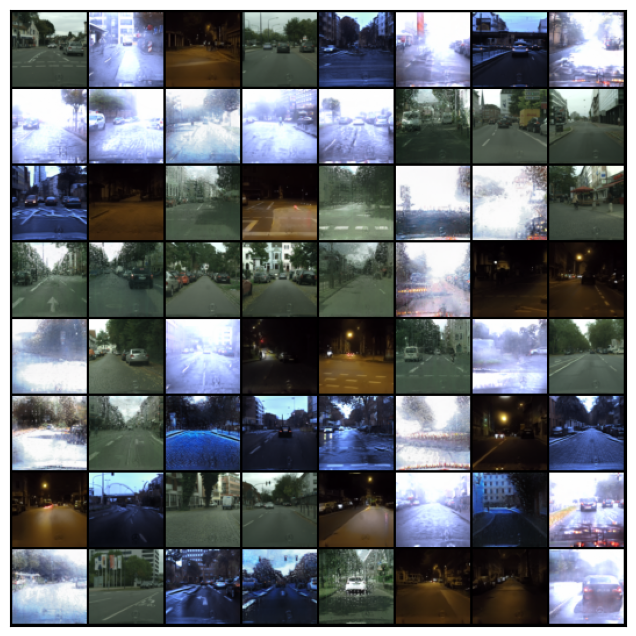

In [11]:
show_batch(train_dl)

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cpu')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

In [15]:
import torch.nn as nn

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


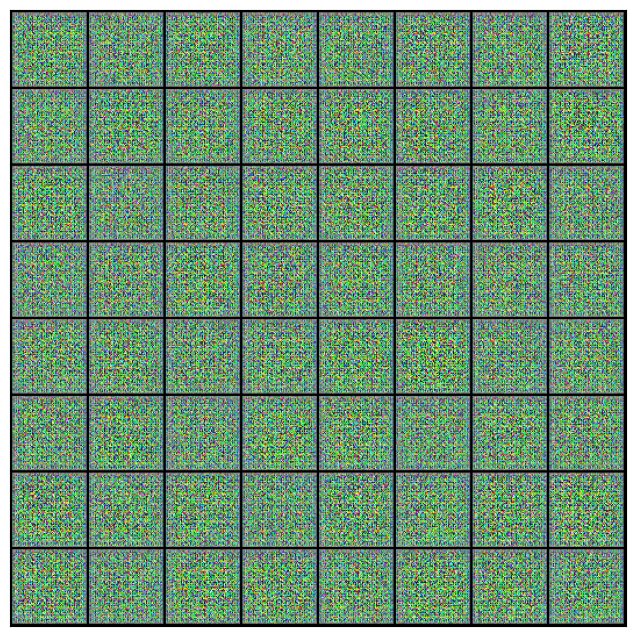

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

In [22]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [23]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [24]:
from torchvision.utils import save_image

In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [27]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999444..0.9998272].


Saving generated-images-0000.png


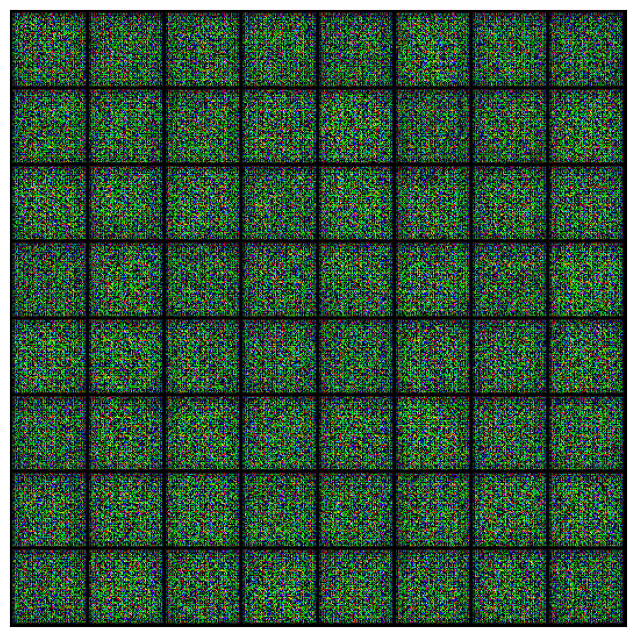

In [28]:
save_samples(0, fixed_latent)

In [29]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [30]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [31]:
lr = 0.0002
epochs = 200

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 7.0836, loss_d: 0.1193, real_score: 0.9208, fake_score: 0.0250
Saving generated-images-0001.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 14.7196, loss_d: 0.0815, real_score: 0.9412, fake_score: 0.0000
Saving generated-images-0002.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 5.6207, loss_d: 0.0239, real_score: 0.9828, fake_score: 0.0057
Saving generated-images-0003.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 15.9376, loss_d: 0.3504, real_score: 0.9952, fake_score: 0.2890
Saving generated-images-0004.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 16.9077, loss_d: 0.0121, real_score: 0.9882, fake_score: 0.0000
Saving generated-images-0005.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 14.0715, loss_d: 0.0099, real_score: 0.9902, fake_score: 0.0000
Saving generated-images-0006.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 18.3162, loss_d: 1.1231, real_score: 0.9956, fake_score: 0.6294
Saving generated-images-0007.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 11.9408, loss_d: 0.0060, real_score: 0.9941, fake_score: 0.0000
Saving generated-images-0008.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 6.5729, loss_d: 0.0335, real_score: 0.9842, fake_score: 0.0169
Saving generated-images-0009.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 6.7469, loss_d: 0.0394, real_score: 0.9889, fake_score: 0.0275
Saving generated-images-0010.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 3.5196, loss_d: 0.0383, real_score: 0.9789, fake_score: 0.0165
Saving generated-images-0011.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 4.5465, loss_d: 0.6385, real_score: 0.6053, fake_score: 0.0095
Saving generated-images-0012.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 2.5128, loss_d: 0.1820, real_score: 0.9548, fake_score: 0.1194
Saving generated-images-0013.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 4.0528, loss_d: 0.6366, real_score: 0.6038, fake_score: 0.0067
Saving generated-images-0014.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 1.0673, loss_d: 1.3990, real_score: 0.8077, fake_score: 0.5296
Saving generated-images-0015.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 2.5461, loss_d: 0.4837, real_score: 0.7116, fake_score: 0.0859
Saving generated-images-0016.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 1.2473, loss_d: 1.0874, real_score: 0.4469, fake_score: 0.0384
Saving generated-images-0017.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 4.9756, loss_d: 0.2758, real_score: 0.9250, fake_score: 0.1691
Saving generated-images-0018.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 1.5650, loss_d: 0.6553, real_score: 0.6614, fake_score: 0.0790
Saving generated-images-0019.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 3.5203, loss_d: 0.3208, real_score: 0.8542, fake_score: 0.1384
Saving generated-images-0020.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 3.5569, loss_d: 0.5915, real_score: 0.7197, fake_score: 0.0800
Saving generated-images-0021.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 3.1185, loss_d: 2.3752, real_score: 0.2259, fake_score: 0.0166
Saving generated-images-0022.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 5.5899, loss_d: 0.5528, real_score: 0.8650, fake_score: 0.2988
Saving generated-images-0023.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 1.9938, loss_d: 1.2169, real_score: 0.4407, fake_score: 0.0711
Saving generated-images-0024.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 1.4816, loss_d: 0.9630, real_score: 0.5465, fake_score: 0.1329
Saving generated-images-0025.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 1.9979, loss_d: 0.6235, real_score: 0.6542, fake_score: 0.0978
Saving generated-images-0026.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 4.4681, loss_d: 0.3585, real_score: 0.9289, fake_score: 0.2331
Saving generated-images-0027.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 4.5794, loss_d: 0.3711, real_score: 0.9249, fake_score: 0.2309
Saving generated-images-0028.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 4.0250, loss_d: 0.5793, real_score: 0.9139, fake_score: 0.3415
Saving generated-images-0029.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 3.1562, loss_d: 0.4205, real_score: 0.8989, fake_score: 0.2522
Saving generated-images-0030.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 3.9340, loss_d: 0.4775, real_score: 0.8366, fake_score: 0.2154
Saving generated-images-0031.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 1.8386, loss_d: 0.4777, real_score: 0.7491, fake_score: 0.1261
Saving generated-images-0032.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 1.0736, loss_d: 1.5074, real_score: 0.2995, fake_score: 0.0322
Saving generated-images-0033.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 1.6998, loss_d: 0.4684, real_score: 0.7529, fake_score: 0.1471
Saving generated-images-0034.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 3.5024, loss_d: 0.4213, real_score: 0.8285, fake_score: 0.1947
Saving generated-images-0035.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 3.2912, loss_d: 0.5271, real_score: 0.8674, fake_score: 0.2891
Saving generated-images-0036.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 2.8912, loss_d: 0.2828, real_score: 0.8854, fake_score: 0.1394
Saving generated-images-0037.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 1.9748, loss_d: 0.5445, real_score: 0.6867, fake_score: 0.1115
Saving generated-images-0038.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 0.8088, loss_d: 1.3685, real_score: 0.3432, fake_score: 0.0543
Saving generated-images-0039.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 2.2064, loss_d: 2.7398, real_score: 0.1989, fake_score: 0.0193
Saving generated-images-0040.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 1.6322, loss_d: 0.5901, real_score: 0.6796, fake_score: 0.1328
Saving generated-images-0041.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 0.9595, loss_d: 0.8543, real_score: 0.5398, fake_score: 0.0911
Saving generated-images-0042.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 0.9152, loss_d: 0.8005, real_score: 0.5390, fake_score: 0.1055
Saving generated-images-0043.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 2.2209, loss_d: 0.5576, real_score: 0.8065, fake_score: 0.2650
Saving generated-images-0044.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 4.8343, loss_d: 0.5085, real_score: 0.8900, fake_score: 0.2958
Saving generated-images-0045.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 1.2415, loss_d: 0.6946, real_score: 0.6622, fake_score: 0.1653
Saving generated-images-0046.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 3.3218, loss_d: 0.4560, real_score: 0.8968, fake_score: 0.2607
Saving generated-images-0047.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 2.7555, loss_d: 0.4946, real_score: 0.6850, fake_score: 0.0530
Saving generated-images-0048.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 2.5558, loss_d: 0.4086, real_score: 0.7229, fake_score: 0.0339
Saving generated-images-0049.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 2.3652, loss_d: 0.4848, real_score: 0.7308, fake_score: 0.1279
Saving generated-images-0050.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 0.6457, loss_d: 1.3574, real_score: 0.3291, fake_score: 0.0898
Saving generated-images-0051.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 3.6072, loss_d: 0.6716, real_score: 0.8352, fake_score: 0.3609
Saving generated-images-0052.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 2.8744, loss_d: 0.3109, real_score: 0.8808, fake_score: 0.1586
Saving generated-images-0053.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 2.3842, loss_d: 0.3272, real_score: 0.8879, fake_score: 0.1727
Saving generated-images-0054.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 1.0371, loss_d: 1.1254, real_score: 0.4079, fake_score: 0.0308
Saving generated-images-0055.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 1.8948, loss_d: 0.7703, real_score: 0.6436, fake_score: 0.2431
Saving generated-images-0056.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 3.9255, loss_d: 0.5677, real_score: 0.8906, fake_score: 0.3425
Saving generated-images-0057.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 4.1509, loss_d: 0.7546, real_score: 0.9468, fake_score: 0.4554
Saving generated-images-0058.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 1.1777, loss_d: 0.7590, real_score: 0.5976, fake_score: 0.1560
Saving generated-images-0059.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 1.8484, loss_d: 0.5699, real_score: 0.7406, fake_score: 0.1945
Saving generated-images-0060.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 3.4371, loss_d: 0.6692, real_score: 0.8278, fake_score: 0.3528
Saving generated-images-0061.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 3.6358, loss_d: 0.7961, real_score: 0.8148, fake_score: 0.3904
Saving generated-images-0062.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 1.8706, loss_d: 0.5526, real_score: 0.6876, fake_score: 0.0961
Saving generated-images-0063.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 0.9751, loss_d: 1.5444, real_score: 0.3194, fake_score: 0.0459
Saving generated-images-0064.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 2.5402, loss_d: 0.6223, real_score: 0.6480, fake_score: 0.1221
Saving generated-images-0065.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 2.7118, loss_d: 0.9009, real_score: 0.5567, fake_score: 0.0437
Saving generated-images-0066.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 3.5408, loss_d: 0.4786, real_score: 0.7795, fake_score: 0.1773
Saving generated-images-0067.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 4.4634, loss_d: 0.6298, real_score: 0.9478, fake_score: 0.4059
Saving generated-images-0068.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 0.9488, loss_d: 0.9292, real_score: 0.4634, fake_score: 0.0651
Saving generated-images-0069.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 2.1418, loss_d: 0.5599, real_score: 0.7446, fake_score: 0.1964
Saving generated-images-0070.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 2.5417, loss_d: 0.6109, real_score: 0.6597, fake_score: 0.1421
Saving generated-images-0071.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 2.7406, loss_d: 0.4496, real_score: 0.7443, fake_score: 0.1188
Saving generated-images-0072.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 0.2082, loss_d: 1.9589, real_score: 0.2390, fake_score: 0.2661
Saving generated-images-0073.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 1.9114, loss_d: 0.6513, real_score: 0.6782, fake_score: 0.1917
Saving generated-images-0074.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 1.7907, loss_d: 0.5575, real_score: 0.6623, fake_score: 0.0919
Saving generated-images-0075.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 2.3948, loss_d: 0.5650, real_score: 0.8265, fake_score: 0.2602
Saving generated-images-0076.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 2.7935, loss_d: 0.3593, real_score: 0.7932, fake_score: 0.1084
Saving generated-images-0077.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 2.5495, loss_d: 0.3549, real_score: 0.7830, fake_score: 0.0771
Saving generated-images-0078.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 1.8354, loss_d: 0.4318, real_score: 0.7663, fake_score: 0.0956
Saving generated-images-0079.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 1.3553, loss_d: 0.8675, real_score: 0.5985, fake_score: 0.2357
Saving generated-images-0080.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 2.6158, loss_d: 0.4529, real_score: 0.7501, fake_score: 0.1258
Saving generated-images-0081.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 3.1612, loss_d: 0.4755, real_score: 0.8170, fake_score: 0.1967
Saving generated-images-0082.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 3.9104, loss_d: 0.9442, real_score: 0.9889, fake_score: 0.5268
Saving generated-images-0083.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 1.4770, loss_d: 0.7923, real_score: 0.5698, fake_score: 0.1480
Saving generated-images-0084.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 2.5127, loss_d: 0.5385, real_score: 0.8934, fake_score: 0.3013
Saving generated-images-0085.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 2.5085, loss_d: 0.4625, real_score: 0.7488, fake_score: 0.1242
Saving generated-images-0086.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 5.9428, loss_d: 1.0925, real_score: 0.8538, fake_score: 0.5504
Saving generated-images-0087.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 2.9042, loss_d: 0.6778, real_score: 0.5665, fake_score: 0.0399
Saving generated-images-0088.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 2.3203, loss_d: 0.5874, real_score: 0.6807, fake_score: 0.1525
Saving generated-images-0089.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 6.3792, loss_d: 1.1232, real_score: 0.9677, fake_score: 0.5878
Saving generated-images-0090.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 3.2081, loss_d: 0.3776, real_score: 0.9372, fake_score: 0.2532
Saving generated-images-0091.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 2.3661, loss_d: 0.9670, real_score: 0.5966, fake_score: 0.2514
Saving generated-images-0092.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 1.2222, loss_d: 0.5507, real_score: 0.6730, fake_score: 0.1070
Saving generated-images-0093.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 1.4601, loss_d: 0.8586, real_score: 0.5798, fake_score: 0.2310
Saving generated-images-0094.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 2.0488, loss_d: 0.8606, real_score: 0.7066, fake_score: 0.3544
Saving generated-images-0095.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 2.4216, loss_d: 0.6043, real_score: 0.7114, fake_score: 0.1896
Saving generated-images-0096.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 1.8549, loss_d: 0.5584, real_score: 0.6569, fake_score: 0.0907
Saving generated-images-0097.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 1.6682, loss_d: 1.1340, real_score: 0.3903, fake_score: 0.0434
Saving generated-images-0098.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 0.4172, loss_d: 1.8046, real_score: 0.2386, fake_score: 0.0855
Saving generated-images-0099.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 2.0327, loss_d: 0.6537, real_score: 0.6484, fake_score: 0.1647
Saving generated-images-0100.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 2.4648, loss_d: 0.4996, real_score: 0.7603, fake_score: 0.1839
Saving generated-images-0101.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 2.6884, loss_d: 0.9593, real_score: 0.6860, fake_score: 0.3904
Saving generated-images-0102.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 1.6710, loss_d: 1.8859, real_score: 0.2070, fake_score: 0.0174
Saving generated-images-0103.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 4.3030, loss_d: 0.8114, real_score: 0.8590, fake_score: 0.4463
Saving generated-images-0104.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 3.1490, loss_d: 0.2531, real_score: 0.8974, fake_score: 0.1263
Saving generated-images-0105.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 3.3838, loss_d: 0.4840, real_score: 0.8594, fake_score: 0.2589
Saving generated-images-0106.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 4.7238, loss_d: 0.5573, real_score: 0.9145, fake_score: 0.3492
Saving generated-images-0107.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 5.5646, loss_d: 0.6124, real_score: 0.9560, fake_score: 0.3957
Saving generated-images-0108.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 2.3703, loss_d: 0.4220, real_score: 0.7798, fake_score: 0.1344
Saving generated-images-0109.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 2.5097, loss_d: 0.6897, real_score: 0.5563, fake_score: 0.0300
Saving generated-images-0110.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 2.3580, loss_d: 0.5858, real_score: 0.6583, fake_score: 0.0692
Saving generated-images-0111.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 1.2891, loss_d: 0.8168, real_score: 0.5339, fake_score: 0.0827
Saving generated-images-0112.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 1.0806, loss_d: 0.8671, real_score: 0.5559, fake_score: 0.1888
Saving generated-images-0113.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 4.2325, loss_d: 0.9350, real_score: 0.9059, fake_score: 0.5310
Saving generated-images-0114.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 3.0079, loss_d: 0.3833, real_score: 0.8592, fake_score: 0.1927
Saving generated-images-0115.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 2.2654, loss_d: 0.5946, real_score: 0.6642, fake_score: 0.1111
Saving generated-images-0116.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 5.3409, loss_d: 0.7458, real_score: 0.9459, fake_score: 0.4633
Saving generated-images-0117.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 5.0270, loss_d: 0.7019, real_score: 0.9205, fake_score: 0.4187
Saving generated-images-0118.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 3.6074, loss_d: 0.3279, real_score: 0.8409, fake_score: 0.1316
Saving generated-images-0119.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 2.4270, loss_d: 3.8323, real_score: 0.0445, fake_score: 0.0010
Saving generated-images-0120.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 1.0400, loss_d: 1.1998, real_score: 0.4711, fake_score: 0.2753
Saving generated-images-0121.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 3.6408, loss_d: 0.5490, real_score: 0.8332, fake_score: 0.2834
Saving generated-images-0122.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 2.0715, loss_d: 0.3527, real_score: 0.8703, fake_score: 0.1752
Saving generated-images-0123.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 3.3306, loss_d: 0.2951, real_score: 0.8686, fake_score: 0.1309
Saving generated-images-0124.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 1.2310, loss_d: 0.8635, real_score: 0.4946, fake_score: 0.0559
Saving generated-images-0125.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 5.0879, loss_d: 0.9870, real_score: 0.9243, fake_score: 0.5385
Saving generated-images-0126.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 3.1459, loss_d: 0.4693, real_score: 0.7196, fake_score: 0.1035
Saving generated-images-0127.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 3.3150, loss_d: 0.4673, real_score: 0.8317, fake_score: 0.2189
Saving generated-images-0128.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 2.1565, loss_d: 0.2925, real_score: 0.8625, fake_score: 0.1217
Saving generated-images-0129.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 3.9254, loss_d: 0.6497, real_score: 0.9350, fake_score: 0.3760
Saving generated-images-0130.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 2.4288, loss_d: 1.8965, real_score: 0.1889, fake_score: 0.0110
Saving generated-images-0131.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 2.2862, loss_d: 0.5263, real_score: 0.8129, fake_score: 0.2347
Saving generated-images-0132.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 1.9964, loss_d: 0.5190, real_score: 0.7080, fake_score: 0.1164
Saving generated-images-0133.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 3.7198, loss_d: 0.5901, real_score: 0.8327, fake_score: 0.3016
Saving generated-images-0134.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 5.4771, loss_d: 0.8377, real_score: 0.9587, fake_score: 0.4979
Saving generated-images-0135.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 5.6534, loss_d: 0.9916, real_score: 0.9315, fake_score: 0.5668
Saving generated-images-0136.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 1.0247, loss_d: 1.2650, real_score: 0.4050, fake_score: 0.2015
Saving generated-images-0137.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 2.7351, loss_d: 0.4574, real_score: 0.8120, fake_score: 0.1970
Saving generated-images-0138.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 3.5571, loss_d: 0.5050, real_score: 0.8140, fake_score: 0.2262
Saving generated-images-0139.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 3.3892, loss_d: 0.5151, real_score: 0.8229, fake_score: 0.2435
Saving generated-images-0140.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 4.3745, loss_d: 0.3630, real_score: 0.9491, fake_score: 0.2511
Saving generated-images-0141.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 1.1240, loss_d: 1.4176, real_score: 0.3362, fake_score: 0.0222
Saving generated-images-0142.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 2.5347, loss_d: 0.5732, real_score: 0.6558, fake_score: 0.1117
Saving generated-images-0143.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 2.9947, loss_d: 0.5038, real_score: 0.8223, fake_score: 0.2268
Saving generated-images-0144.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 4.6028, loss_d: 0.4834, real_score: 0.9017, fake_score: 0.2868
Saving generated-images-0145.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 2.9727, loss_d: 0.7734, real_score: 0.8100, fake_score: 0.3704
Saving generated-images-0146.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 1.2496, loss_d: 0.9077, real_score: 0.5017, fake_score: 0.1279
Saving generated-images-0147.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 1.8983, loss_d: 0.8802, real_score: 0.4968, fake_score: 0.0282
Saving generated-images-0148.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 3.7900, loss_d: 0.4340, real_score: 0.9213, fake_score: 0.2753
Saving generated-images-0149.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 1.1637, loss_d: 0.8531, real_score: 0.5032, fake_score: 0.0726
Saving generated-images-0150.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 2.7308, loss_d: 0.3558, real_score: 0.8526, fake_score: 0.1604
Saving generated-images-0151.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 2.3467, loss_d: 0.4029, real_score: 0.7937, fake_score: 0.1410
Saving generated-images-0152.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 2.3502, loss_d: 0.5001, real_score: 0.6755, fake_score: 0.0491
Saving generated-images-0153.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 3.6981, loss_d: 0.3399, real_score: 0.8764, fake_score: 0.1751
Saving generated-images-0154.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 2.0256, loss_d: 0.4418, real_score: 0.8298, fake_score: 0.1964
Saving generated-images-0155.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 1.9801, loss_d: 0.9200, real_score: 0.5691, fake_score: 0.2446
Saving generated-images-0156.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 3.0906, loss_d: 0.3402, real_score: 0.7983, fake_score: 0.0806
Saving generated-images-0157.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 1.0405, loss_d: 0.7666, real_score: 0.6091, fake_score: 0.1675
Saving generated-images-0158.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 4.9019, loss_d: 0.5516, real_score: 0.8635, fake_score: 0.2992
Saving generated-images-0159.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 3.9522, loss_d: 0.4800, real_score: 0.8609, fake_score: 0.2352
Saving generated-images-0160.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 3.6111, loss_d: 0.4248, real_score: 0.8157, fake_score: 0.1635
Saving generated-images-0161.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 4.7700, loss_d: 0.6115, real_score: 0.8684, fake_score: 0.3424
Saving generated-images-0162.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 2.5651, loss_d: 0.3702, real_score: 0.7324, fake_score: 0.0374
Saving generated-images-0163.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 0.1192, loss_d: 1.6618, real_score: 0.2451, fake_score: 0.0395
Saving generated-images-0164.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 4.1960, loss_d: 0.4834, real_score: 0.8671, fake_score: 0.2659
Saving generated-images-0165.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 1.7260, loss_d: 0.8229, real_score: 0.5545, fake_score: 0.1413
Saving generated-images-0166.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 3.1163, loss_d: 0.4526, real_score: 0.7945, fake_score: 0.1711
Saving generated-images-0167.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 1.2409, loss_d: 0.4399, real_score: 0.7083, fake_score: 0.0714
Saving generated-images-0168.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 1.4557, loss_d: 0.7996, real_score: 0.5863, fake_score: 0.1729
Saving generated-images-0169.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 0.4673, loss_d: 1.3596, real_score: 0.3845, fake_score: 0.1642
Saving generated-images-0170.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 4.0073, loss_d: 0.4919, real_score: 0.9599, fake_score: 0.3260
Saving generated-images-0171.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 3.9659, loss_d: 0.4622, real_score: 0.9323, fake_score: 0.2847
Saving generated-images-0172.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 1.8334, loss_d: 0.6169, real_score: 0.5991, fake_score: 0.0396
Saving generated-images-0173.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 4.0239, loss_d: 0.4779, real_score: 0.9322, fake_score: 0.2857
Saving generated-images-0174.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 3.4523, loss_d: 0.4809, real_score: 0.8132, fake_score: 0.2071
Saving generated-images-0175.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 3.8329, loss_d: 0.3403, real_score: 0.8599, fake_score: 0.1533
Saving generated-images-0176.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 3.1087, loss_d: 0.2309, real_score: 0.9155, fake_score: 0.1207
Saving generated-images-0177.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 6.2511, loss_d: 0.8381, real_score: 0.9706, fake_score: 0.5036
Saving generated-images-0178.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 1.9151, loss_d: 0.4931, real_score: 0.6631, fake_score: 0.0459
Saving generated-images-0179.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 4.2188, loss_d: 0.7222, real_score: 0.8395, fake_score: 0.3529
Saving generated-images-0180.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 3.6329, loss_d: 0.4453, real_score: 0.8917, fake_score: 0.2572
Saving generated-images-0181.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 3.2531, loss_d: 0.2803, real_score: 0.8944, fake_score: 0.1452
Saving generated-images-0182.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 4.3055, loss_d: 0.5251, real_score: 0.9232, fake_score: 0.3181
Saving generated-images-0183.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 1.6575, loss_d: 0.4163, real_score: 0.7462, fake_score: 0.0972
Saving generated-images-0184.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 2.7697, loss_d: 0.6258, real_score: 0.6900, fake_score: 0.1667
Saving generated-images-0185.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 2.8846, loss_d: 0.6844, real_score: 0.7014, fake_score: 0.2244
Saving generated-images-0186.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 1.6363, loss_d: 0.4507, real_score: 0.7582, fake_score: 0.1262
Saving generated-images-0187.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 5.2239, loss_d: 0.6690, real_score: 0.9342, fake_score: 0.4024
Saving generated-images-0188.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 4.8903, loss_d: 0.5902, real_score: 0.9228, fake_score: 0.3435
Saving generated-images-0189.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 3.5061, loss_d: 0.2809, real_score: 0.8814, fake_score: 0.1328
Saving generated-images-0190.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 4.2739, loss_d: 0.4848, real_score: 0.9113, fake_score: 0.2942
Saving generated-images-0191.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 0.9012, loss_d: 1.6274, real_score: 0.3285, fake_score: 0.0187
Saving generated-images-0192.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 0.6567, loss_d: 1.5883, real_score: 0.2712, fake_score: 0.0290
Saving generated-images-0193.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 1.9317, loss_d: 0.7618, real_score: 0.6219, fake_score: 0.1753
Saving generated-images-0194.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 1.7910, loss_d: 0.5257, real_score: 0.7328, fake_score: 0.1592
Saving generated-images-0195.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 3.8462, loss_d: 0.1789, real_score: 0.9451, fake_score: 0.1103
Saving generated-images-0196.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 2.7356, loss_d: 0.5448, real_score: 0.8093, fake_score: 0.2448
Saving generated-images-0197.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 4.1185, loss_d: 0.2320, real_score: 0.9301, fake_score: 0.1397
Saving generated-images-0198.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 4.2249, loss_d: 0.1609, real_score: 0.8944, fake_score: 0.0431
Saving generated-images-0199.png


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 4.5606, loss_d: 0.4305, real_score: 0.8899, fake_score: 0.2442
Saving generated-images-0200.png


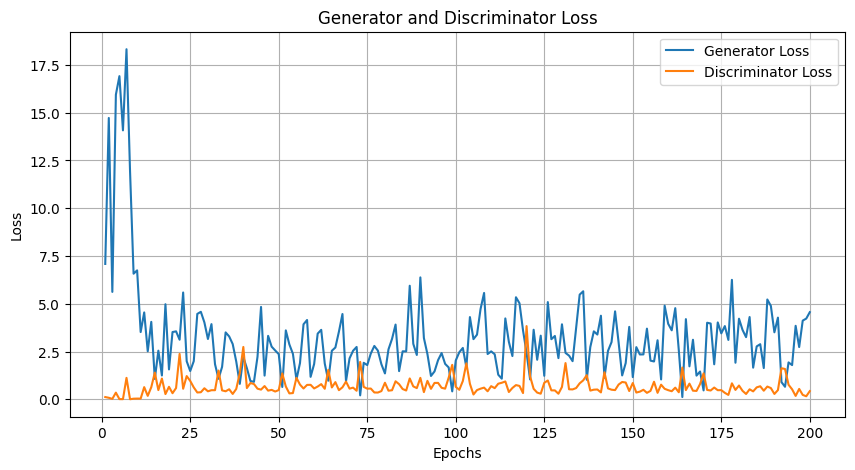

In [32]:
# Define learning rate and number of epochs
lr = 0.0002
epochs = 200

# Train the GAN
losses_g, losses_d, real_scores, fake_scores = fit(epochs, lr)

# Now proceed to plot or analyze the results
import matplotlib.pyplot as plt

# Example: Plotting generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses_g) + 1), losses_g, label='Generator Loss')
plt.plot(range(1, len(losses_d) + 1), losses_d, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss')
plt.legend()
plt.grid()
plt.show()


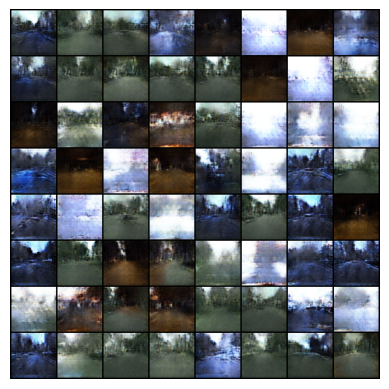

In [34]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the image
image_path = "generated/generated-images-0197.png"  

# Load the image using PIL
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes for a clean display
plt.show()
